# Requirement 2
## *Multiple product and stochastic environment*

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

### Environment
A stochastic environment, where we have a joint distribution over the valuations of all the types of products

In [90]:
class MultipleProductEnvironment:
  def __init__(self, T, N, valuations_distr):
    self.T = T # Number of buyers (rounds)
    self.N = N # Number of types of products
    self.t = 0 # Current buyer
    # Valuation of each buyer sampled from the given distribution function
    self.valuations = []
    for distr in valuations_distr:
      self.valuations.append(distr.rvs(size=T))

    self.valuations = np.array(self.valuations).transpose()

  def round(self, p_t):
    reward = np.array([])

    # Check if the buyer valuations are higher than products prices
    for valuation, price in zip(self.valuations[self.t, :], p_t):
      if valuation >= price:
        reward = np.append(reward, price)
      else:
        reward = np.append(reward, 0.)

    # Update round
    self.t = self.t + 1
    return reward

### Agent - *Combinatorial-UCB algorithm* **with inventory constraint**

In [91]:
class CombinatorialUCB:
    def __init__(self, T, B, P, N, range=1):
        self.T = T
        self.P = P
        self.N = N
        self.budget = B
        self.range = range

        self.avg_f = np.zeros((N, P))
        self.avg_c = np.zeros((N, P))
        self.N_pulls = np.zeros((N, P))

        self.pi_t = None

        self.t = 0

    def compute_opt(self, f_ucbs, c_lcbs):
        # Total variables
        tot_vars = self.N * self.P

        # Per-round budget
        rho = (self.budget / (self.T - self.t + 1)) + 1.5

        # Variables
        c = -f_ucbs

        A_ub = [c_lcbs]
        b_ub = [rho]

        A_eq = []
        b_eq = []
        var_index = 0
        for i in range(self.N):
            eq_row = np.zeros(tot_vars)
            eq_row[var_index:var_index + self.P] = 1
            A_eq.append(eq_row)
            b_eq.append(1)
            var_index = var_index + self.P

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=[(0, 1) for _ in range(tot_vars)]
        )
        
        if res.success:
            gamma = []
            solution = res.x
            var_index = 0
            for i in range(self.N): 
                gamma_i = solution[var_index : var_index + self.P]
                gamma_i = gamma_i / gamma_i.sum()  # Ensure normalization
                gamma_i = np.abs(gamma_i)
                gamma.append(gamma_i)
                var_index = var_index + self.P
            return gamma
        else:
            # Select UCB-maximizing price for each product
            return [np.eye(self.P)[np.argmax(f_ucbs[i])] for i in range(self.N)]

    def pull_arm(self):
        # Check if budget is depleted
        if self.budget < 1:
            return np.array([None  for _ in range(self.N)])

        # Exploration: try each price vector at least once
        if self.t < self.P:
            self.pi_t = np.array([self.t for _ in range(self.N)])
        else:
            # Initialize f_ucb and c_ucb for each arm (matrix)
            f_ucbs = np.zeros(self.avg_f.shape, dtype=float)
            c_lcbs = np.zeros(self.avg_c.shape, dtype=float)

            # For each unexplored arm, set a large value of f_ucb and 0 c_ucb
            #large_value = (1 + np.sqrt(2*np.log(self.T)/1))*10
            large_value = 1e10
            unexplored = (self.N_pulls == 0)
            f_ucbs[unexplored] = large_value
            c_lcbs[unexplored] = 0

            # Get the mask of the arms that have been pulled at least one time
            # and then set the f_ucb and c_ucb for these arms
            mask = self.N_pulls > 0
            f_ucbs[mask] = self.avg_f[mask] + self.range * np.sqrt(2 * np.log(self.T)/self.N_pulls[mask])
            c_lcbs[mask] = self.avg_c[mask] - self.range * np.sqrt( 2 * np.log(self.T)/self.N_pulls[mask])
            c_lcbs[c_lcbs < 0] = 0

            # Optimal distribution over superarms
            gamma = self.compute_opt(f_ucbs.reshape(-1), c_lcbs.reshape(-1))

            # Set current prices
            sampled_indices = []
            for i in range(self.N):
                sampled_indices.append(np.random.choice(self.P, p=gamma[i]))
            self.pi_t = sampled_indices
        
        return self.pi_t

    def update(self, f_t, c_t):
        # Update the number of pulls of each arm in played superarm
        for i in range(self.N):
            self.N_pulls[i][self.pi_t[i]] += 1

            # Update empirical means
            self.avg_f[i][self.pi_t[i]] += (f_t[i] - self.avg_f[i][self.pi_t[i]])/self.N_pulls[i][self.pi_t[i]]
            self.avg_c[i][self.pi_t[i]] += (c_t[i] - self.avg_c[i][self.pi_t[i]])/self.N_pulls[i][self.pi_t[i]]

        # Update budget
        self.budget = self.budget - np.sum(c_t)

        self.t += 1

### Clairvoyant - **with inventory constraint**

In [92]:
class MultipleProductInventoryClairvoyant:
    def __init__(self, T, B, N, prices, valuations_distr):
        self.T = T
        self.prices = prices
        self.budget = B
        self.N = N
        self.P = len(prices)

        self.valuations_distr = valuations_distr

    def get_selling_probabilities(self):
        obj = [1 - distr.cdf(self.prices) for distr in self.valuations_distr]
        return np.array(obj)    

    def run(self):
        # Probability of selling of each price for each chosen distributions of product valuations
        selling_prob = self.get_selling_probabilities()
        
        # Per-round budget
        rho = np.sum(np.min(selling_prob, axis=1)) + 1

        # Number of variables
        tot_vars = self.N * self.P

        # Linear programming 
        c = -(selling_prob * self.prices).reshape(-1)

        A_ub = [selling_prob.reshape(-1)]
        b_ub = [rho]

        A_eq = []
        b_eq = []
        var_index = 0
        for _ in range(self.N):
            eq_row = np.zeros(tot_vars)
            eq_row[var_index:var_index + self.P] = 1
            A_eq.append(eq_row)
            b_eq.append(1)
            var_index = var_index + self.P

        res = optimize.linprog(
            c, 
            A_ub=A_ub, 
            b_ub=b_ub, 
            A_eq=A_eq, 
            b_eq=b_eq, 
            bounds=[(0, 1) for _ in range(tot_vars)]
        )

        expected_utility = np.array([-res.fun for _ in range(self.T)])

        return expected_utility

### Execution

In [93]:
# Parameters
T = 10000
B = T * 75/100

# Prices
max_price = 1
price_step = 0.2
prices = np.arange(0, max_price, price_step)
P = len(prices)

# Valuation prob. distribution  
valuations_distr = [
    stats.norm(loc=0.5, scale=1),
    stats.beta(a=3, b=2),
    stats.beta(a=2, b=20),
]

N = len(valuations_distr)

In [94]:
# Run clairvoyant
clairvoyant = MultipleProductInventoryClairvoyant(T, B, N, prices, valuations_distr)
expected_clairvoyant_utilities = clairvoyant.run()
expected_clairvoyant_utilities

array([0.64552008, 0.64552008, 0.64552008, ..., 0.64552008, 0.64552008,
       0.64552008], shape=(10000,))

In [95]:
n_trials = 10
regret_per_trial = []
for trial in range(n_trials):

  # Define environment and agent
  env = MultipleProductEnvironment(T, N, valuations_distr)
  combinatorial_ucb = CombinatorialUCB(T, B, P, N, range=max_price)

  agent_rewards = []
  for t in range(T):
    # This returns the price index
    pi_t = combinatorial_ucb.pull_arm()

    # Check if budget is depleted -> reward always 0
    if np.any(pi_t == None):
      r_t = np.zeros(N)
    else:
      # Get the actual price
      p_t = prices[pi_t]

      # Get rewardx
      r_t = env.round(p_t)

      # Update agent state
      combinatorial_ucb.update(r_t, r_t > 0.)

    agent_rewards.append(np.sum(r_t))

  agent_rewards = np.array(agent_rewards)
  cumulative_regret = np.cumsum(expected_clairvoyant_utilities - agent_rewards)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)
average_regret = regret_per_trial.mean(axis=0) # mean
regret_sd = regret_per_trial.std(axis=0) # standard deviation

### Results

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/32/cjb5rw_97rjb1kkd58x5p4q80000gn/T/ipykernel_75922/3178877594.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(t - 1, theoretical_curve, label="$(\sqrt{NPTlog(T)})$", linestyle="--", color="red")


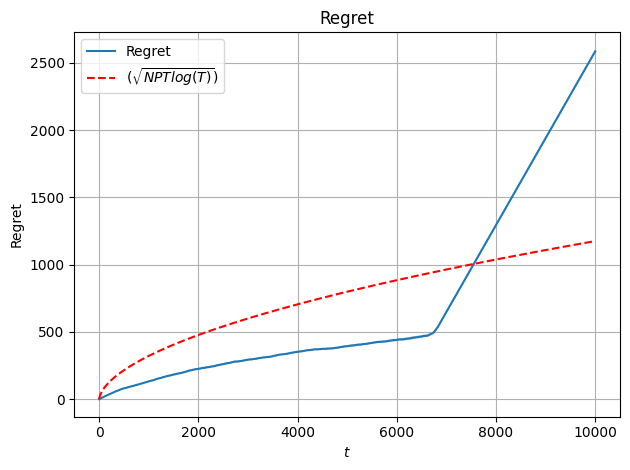

In [107]:
plt.plot(np.arange(T), average_regret, label=f'Regret')
plt.fill_between(
    np.arange(T),
    average_regret-regret_sd/np.sqrt(n_trials),
    average_regret+regret_sd/np.sqrt(n_trials),
    alpha=0.3
)

t = np.arange(1, T + 1)  # da 1 per evitare log(0)
theoretical_curve = (N*P*t*np.log(t))**(1/2)
plt.plot(t - 1, theoretical_curve, label="$(\sqrt{NPTlog(T)})$", linestyle="--", color="red")

plt.xlabel("$t$")
plt.ylabel("Regret")
plt.title("Regret")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()